In [42]:
from sklearn.datasets import fetch_openml as fetch_mldata

mnist = fetch_mldata("mnist_784")
mnist

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0           0       0       0       0       0       0       0       0       0   
 1           0       0       0       0       0       0       0       0       0   
 2           0       0       0       0       0       0       0       0       0   
 3           0       0       0       0       0       0       0       0       0   
 4           0       0       0       0       0       0       0       0       0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995       0       0       0       0       0       0       0       0       0   
 69996       0       0       0       0       0       0       0       0       0   
 69997       0       0       0       0       0       0       0       0       0   
 69998       0       0       0       0       0       0       0       0       0   
 69999       0       0       0       0       0       0       0       0       0   
 
      

In [43]:
import numpy as np

X, y = np.array(mnist['data']), np.array(mnist['target'])

display(X.shape)
display(y.shape)

(70000, 784)

(70000,)

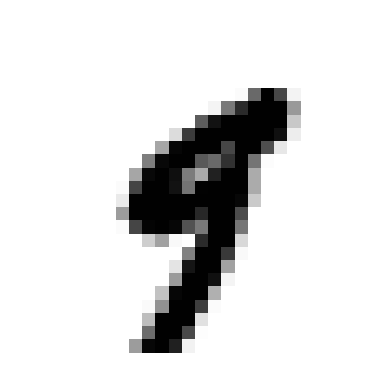

9


In [44]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest') # type: ignore
plt.axis('off')

plt.show()

print(y[36000])

In [45]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [46]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [47]:
y_train_9 = (y_train.astype(int) == 9)
y_test_9 = (y_test.astype(int) == 9)

In [48]:
y_test_9[:20]

array([False, False, False, False, False, False, False,  True, False,
        True, False, False,  True, False, False, False,  True, False,
       False, False])

In [49]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train, y_train_9)

SGDClassifier(n_jobs=-1, random_state=42)

In [50]:
sgd_clf.predict([some_digit])

array([False])

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_clf = clone(sgd_clf)

    X_train_folds = X_train[train_index]
    y_train_folds = y_train_9[train_index]

    X_test_fold = X_train[test_index]
    y_test_fold = y_train_9[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)

    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.94555
0.9395
0.94965


In [52]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring='accuracy', n_jobs=-1)

array([0.94835, 0.9445 , 0.95495])

In [53]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [54]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring='accuracy', n_jobs=-1)

array([0.901  , 0.90415, 0.8974 ])

In [55]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, n_jobs=-1)

|Confusion Matrix| Predicted Negative | Predictied Positive |
| :-----------: | :----------: | :------------------: |
| **Actually Negative** | True Negative (TN) | False Positive (FP) |
| **Actually Positive** | False Negative (FN) | True Positive (TP) |

In [56]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

array([[52995,  1056],
       [ 1988,  3961]])

In [57]:
y_train_perfect_predictions = y_train_9.copy()

confusion_matrix(y_train_9, np.zeros((len(X_train), 1), dtype=bool))

array([[54051,     0],
       [ 5949,     0]])

Precision: $ precision = {TP \over {TP + FP}} $

Recall: $ recall = {TP \over {TP + FN}} $

In [58]:
from sklearn.metrics import precision_score, recall_score

display(precision_score(y_train_9, y_train_pred))
display(recall_score(y_train_9, y_train_pred))

0.789515646800877

0.6658261892755085

F<sub>1</sub> Score: $$F_1 = {2 \over {1 \over precision} + {1 \over recall}} = {2 \cdot {precision \cdot recall \over {precision} + {recall}}} = {TP \over TP +{{FN + FP} \over 2}}$$

In [59]:
from sklearn.metrics import f1_score

f1_score(y_train_9, y_train_pred)

0.7224147364581434

In [60]:
y_scores = sgd_clf.decision_function([some_digit])
display(y_scores)

threshold = -2000
y_some_digit_pred = (y_scores > threshold)
display(y_some_digit_pred)

array([-5166.50693364])

array([False])

In [61]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function", n_jobs=-1)

In [62]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

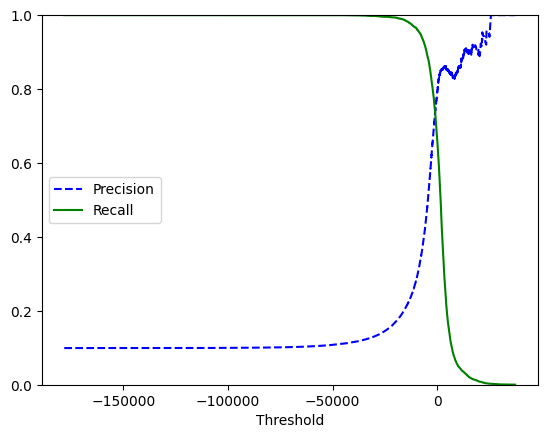

In [63]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, drop_last=1):
    if drop_last:
        precisions = precisions[:-drop_last]
        recalls = recalls[:-drop_last]
    
    plt.plot(thresholds, precisions, 'b--', label="Precision")
    plt.plot(thresholds, recalls, 'g-', label="Recall")

    plt.xlabel("Threshold")
    
    plt.legend(loc='center left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

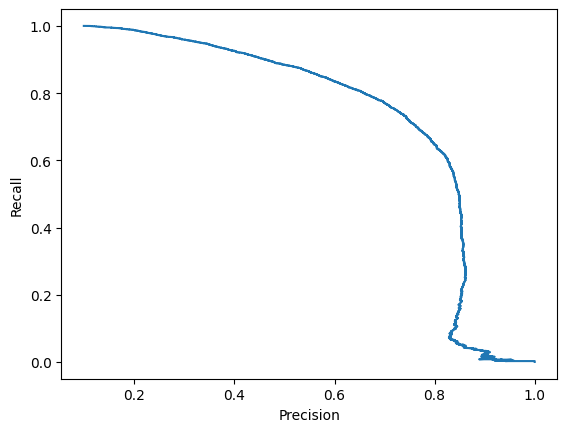

In [64]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(precisions[:-1], recalls[:-1])

    plt.xlabel("Precision")
    plt.ylabel("Recall")

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [65]:
y_train_pred_90 = (y_scores > -2690)

display(precision_score(y_train_9, y_train_pred_90))
display(recall_score(y_train_9, y_train_pred_90))

0.620222728423184

0.8238359388132459

*TPR* (True Positive Rate): $ {TP \over {TP + FN}} = recall $ (sensitivity)

*FPR* (False Positive Rate): $ 1 - TNR = {1 - {TN \over {TN + FP}}} = {FP \over {TN + FP}} = 1 - specificty $ (TNR is True Negatvie Rate also specificty)

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

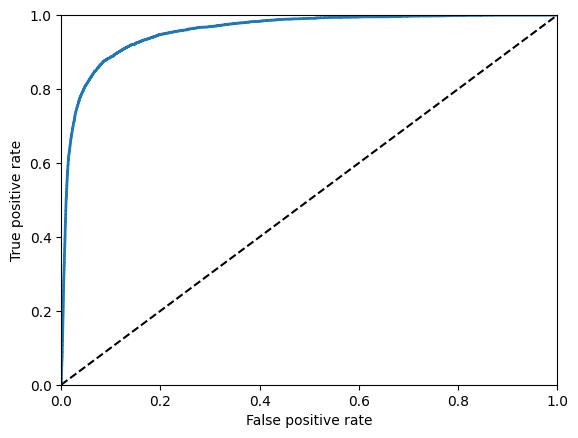

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) # type: ignore

    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")

plot_roc_curve(fpr, tpr)
plt.show()

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9574716418611624

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method='predict_proba', n_jobs=-1)

In [70]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_9, y_scores_forest)

'''
[[not9, 9], 
 [not9, 9], 
 [not9, 9]]
'''

'\n[[not9, 9], \n [not9, 9], \n [not9, 9]]\n'

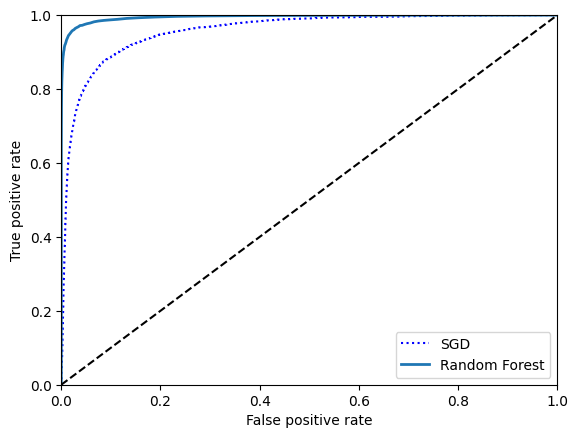

In [71]:
plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')

plt.show()

In [72]:
roc_auc_score(y_train_9, y_scores_forest)

0.9949163814173387

In [73]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, n_jobs=-1)

display(precision_score(y_train_9, y_pred_forest))
display(recall_score(y_train_9, y_pred_forest))

0.9823113207547169

0.8401412002017146

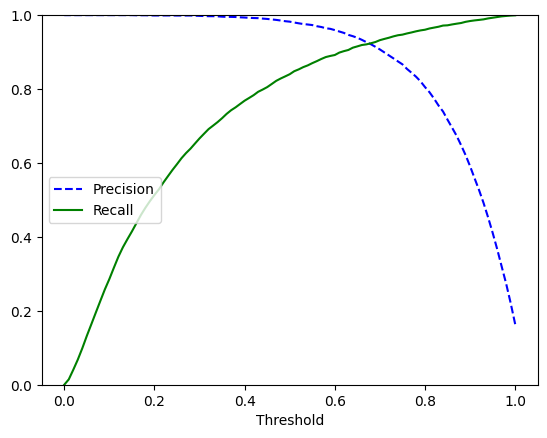

In [77]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_9, y_scores_forest)
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, threshold_forest, drop_last=0)

- One vs all (OvA), train $ N $ classifiers
- One vs One (OvO), trains $ {N \cdot (N - 1)} \over 2 $ classifiers

In [78]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['4'], dtype='<U1')

In [79]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-25338.82153255, -23674.75419181, -21428.01362764,
         -2017.48890359,   -634.79834934,  -4303.29637543,
        -27995.45570546,  -8343.31698621,  -3905.66535079,
         -1747.86016566]])

In [80]:
display(np.argmax(some_digit_scores))

display(sgd_clf.classes_)
sgd_clf.classes_[9]

4

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

'9'

In [81]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, n_jobs=-1), n_jobs=-1)
ovo_clf.fit(X_train, y_train)

display(ovo_clf.predict([some_digit]))

len(ovo_clf.estimators_)

array(['4'], dtype=object)

45

In [82]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['9'], dtype=object)

In [83]:
forest_clf.predict_proba([some_digit])

array([[0.01, 0.01, 0.  , 0.01, 0.04, 0.  , 0.  , 0.01, 0.02, 0.9 ]])

In [84]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.8562 , 0.869  , 0.86085])

In [85]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.96655, 0.96595, 0.96415])

In [86]:
display(X_train[0])

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  28,
       127, 171, 254, 194, 156, 156, 104,  14,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)

/home/bill/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.9042 , 0.90505, 0.89255])

In [88]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=-1)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/bill/.local/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[5593,    0,   17,    7,    6,   38,   37,    6,  218,    1],
       [   0, 6415,   42,   23,    3,   41,    5,    7,  196,   10],
       [  25,   29, 5258,   83,   70,   23,   67,   40,  356,    7],
       [  27,   19,  115, 5245,    1,  188,   26,   37,  408,   65],
       [  11,   13,   45,   14, 5223,    8,   37,   25,  310,  156],
       [  26,   15,   27,  153,   54, 4470,   78,   18,  514,   66],
       [  31,   14,   48,    2,   38,   78, 5564,    7,  136,    0],
       [  17,   12,   50,   24,   47,   14,    4, 5706,  183,  208],
       [  15,   63,   39,   88,    4,  116,   32,    8, 5442,   44],
       [  24,   22,   28,   58,  120,   36,    1,  177,  363, 5120]])

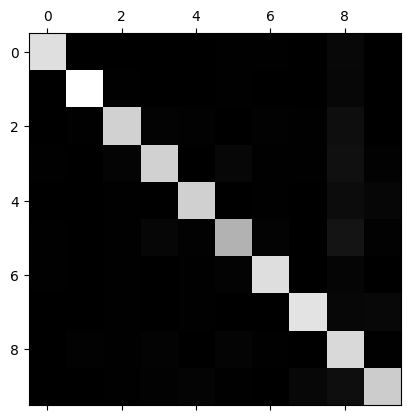

In [89]:
plt.matshow(conf_mx, cmap=plt.cm.gray) # type: ignore
plt.show()

In [90]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

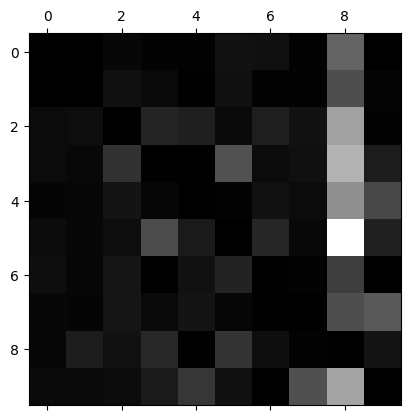

In [91]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray) # type: ignore
plt.show()

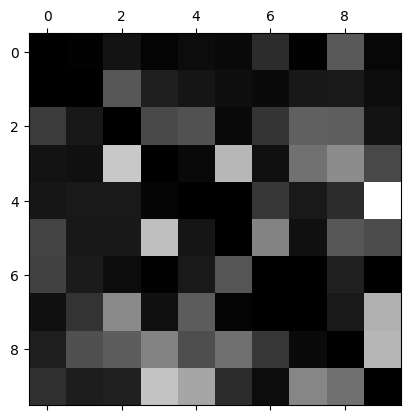

In [92]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, n_jobs=-1)

conf_mx_forest = confusion_matrix(y_train, y_train_pred_forest)

row_sums_forest = conf_mx_forest.sum(axis=1, keepdims=True)
norm_conf_mx_forest = conf_mx_forest / row_sums_forest

np.fill_diagonal(norm_conf_mx_forest, 0)

plt.matshow(norm_conf_mx_forest, cmap=plt.cm.gray) # type: ignore
plt.show()

In [93]:
def plot_digits(instances, images_per_row=10, **options):
    try:
        print(f"Error rate {len(instances)}")
        size = 28
        images_per_row = min(len(instances), images_per_row)
        
        images = [instance.reshape(size,size) for instance in instances]
        n_rows = (len(instances) - 1) // images_per_row + 1
        
        row_images = []
        
        n_empty = n_rows * images_per_row - len(instances)
        images.append(np.zeros((size, size * n_empty)))
        
        for row in range(n_rows):
            rimages = images[row * images_per_row : (row + 1) * images_per_row]
            row_images.append(np.concatenate(rimages, axis=1))
        
        image = np.concatenate(row_images, axis=0)
        plt.imshow(image, cmap = plt.cm.binary, **options) # type: ignore
        plt.axis("off")
    except:
        print(f"There are no instances")

False
Error rate 25
Error rate 4
Error rate 2
Error rate 25


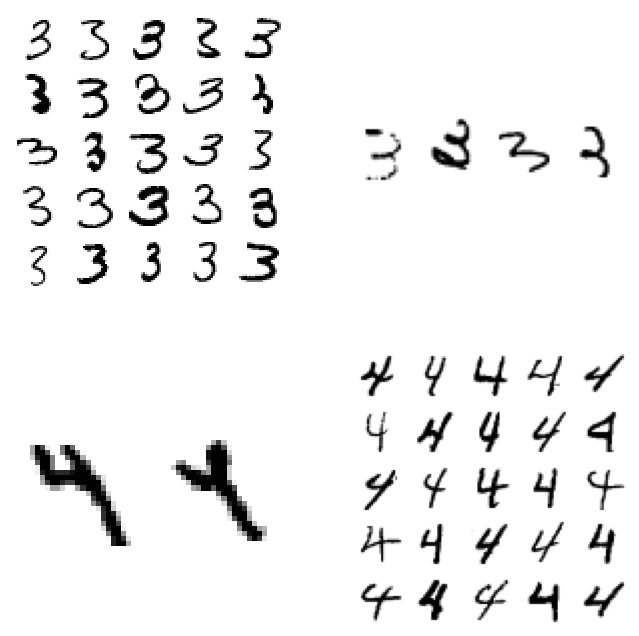

In [94]:
cl_a, cl_b = 3, 4

preds = y_train_pred_forest.copy() # type: ignore

y_train = y_train.astype(int)
preds = preds.astype(int)

X_aa = X_train[(y_train == cl_a) & (preds == cl_a)]
X_ab = X_train[(y_train == cl_a) & (preds == cl_b)]
X_ba = X_train[(y_train == cl_b) & (preds == cl_a)]
X_bb = X_train[(y_train == cl_b) & (preds == cl_b)]

print(y_train.astype(int)[0] == 3)

plt.figure(figsize=(8, 8))

plt.subplot(221) ; plot_digits(X_aa[:25], images_per_row=5) # type: ignore
plt.subplot(222) ; plot_digits(X_ab[:25], images_per_row=5) # type: ignore
plt.subplot(223) ; plot_digits(X_ba[:25], images_per_row=5) # type: ignore
plt.subplot(224) ; plot_digits(X_bb[:25], images_per_row=5) # type: ignore

plt.show()

In [95]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

In [96]:
knn_clf.predict([some_digit])

array([[ True,  True]])

In [97]:
y_train_knn_predict = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_predict, average='macro')

0.976651079226045

In [98]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [99]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

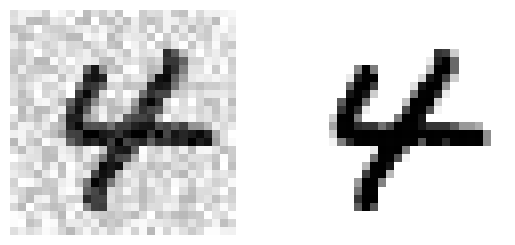

In [100]:
some_index = 5500

plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

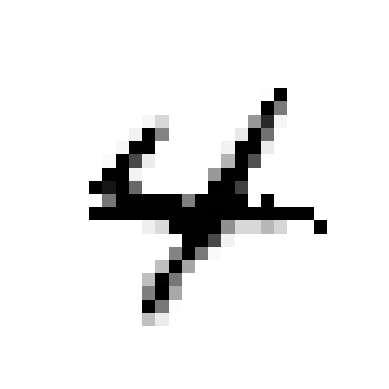

In [101]:
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [102]:
from sklearn.model_selection import GridSearchCV

good_model = KNeighborsClassifier(n_jobs=-1)
params = {'n_neighbors': np.arange(1, 10)}

grid = GridSearchCV(good_model, params, cv=5, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.971 total time=  15.7s
[CV 2/5] END .....................n_neighbors=1;, score=0.971 total time=  16.1s
[CV 3/5] END .....................n_neighbors=1;, score=0.973 total time=  15.7s
[CV 4/5] END .....................n_neighbors=1;, score=0.973 total time=  16.2s
[CV 5/5] END .....................n_neighbors=1;, score=0.971 total time=  15.7s
[CV 1/5] END .....................n_neighbors=2;, score=0.964 total time=  16.5s
[CV 2/5] END .....................n_neighbors=2;, score=0.965 total time=  16.1s
[CV 3/5] END .....................n_neighbors=2;, score=0.968 total time=  16.2s
[CV 4/5] END .....................n_neighbors=2;, score=0.964 total time=  15.9s
[CV 5/5] END .....................n_neighbors=2;, score=0.963 total time=  16.4s
[CV 1/5] END .....................n_neighbors=3;, score=0.972 total time=  17.4s
[CV 2/5] END .....................n_neighbors=3;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             verbose=3)

In [103]:
grid.best_params_

{'n_neighbors': 3}

In [104]:
grid.best_score_

0.9719166666666667

In [105]:
class ShiftImage(BaseEstimator):
    def __init__(self, shuffle=True):
        self.shuffle = shuffle
    
    def fit(self, X, y=None):
        return X, y
    
    def transform(self, X, y, shifts=[[-1, 0], [1, 0], [0, 1], [0, -1]], multiplier=1):
        shifts = shifts * multiplier
        
        from scipy.ndimage.interpolation import shift

        images = X.reshape((-1, 28, 28))
        
        shifted_images = []
        shifted_labels = []
        
        for image, label in zip(images, y):
            for shift_amt in shifts:
                new_image = np.array(shift(image, shift_amt, cval=0, mode="constant"))
                new_image = new_image.reshape([-1])

                shifted_images.append(new_image)
                shifted_labels.append(label)
        
        shifted_images = np.array(shifted_images)
        shifted_labels = np.array(shifted_labels)

        if self.shuffle:
            shuffle_idx = np.random.permutation(len(shifted_images))
            shifted_images = shifted_images[shuffle_index]
            shifted_labels = shifted_labels[shuffle_index]

        return shifted_images, shifted_labels



: 

In [106]:
shift = ShiftImage()
X_train_augmented, y_train_augmented = shift.transform(X_train, y_train, multiplier=5)

/tmp/ipykernel_720650/2162360934.py:11: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [ ]:
best_model = grid.best_estimator_
grid.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_test.astype(int))
accuracy_score(y_test.astype(int), y_pred)

0.9354

In [ ]:
print(y_pred)
print(y_test)

[7 2 1 ... 9 5 6]
['7' '2' '1' ... '4' '5' '6']
